In [7]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.stats import bernoulli

from exchange import *
from agents import *
from simulation import *

plt.rcParams['figure.dpi'] = 300

In [2]:
def execute_policy(e: Exchange, price_function, policy_number: int):
    # main character params: true_value, quantity, side, spread, cid

    if list(e.bids.keys()) != [] and list(e.asks.keys()) != []:
        tob_bid = max(e.bids.keys())
        tob_ask = min(e.asks.keys())
    else: 
        return
    current_true_value = price_function(e.get_timestamp())

    policies = []

    ### quote 6 wide around 100 ###
    policies.append(MainCharacter(true_value=100, quantity=10, side="AB", spread=3, cid=-1.5))

    ### quote 2 wide around 100 ### 
    policies.append(MainCharacter(true_value=100, quantity=10, side="AB", spread=1, cid=-2.5))

    ### quote 2 wide around 100, quantity 1 ###
    policies.append(MainCharacter(true_value=100, quantity=1, side="AB", spread=1, cid=-3.5))

    ### quote 2 wide around true val (perfect information) ###
    policies.append(MainCharacter(true_value = price_function(e.get_timestamp()), quantity=5, side="AB", spread=1, cid=-4.5))

    ### quote 2 wide around true val 10 timestamps ago ### 
    policies.append(MainCharacter(true_value=price_function(e.get_timestamp() - 10), quantity=5, side="AB", spread=1, cid=-5.5))

    ### quote 2 wide around true value 10 timestamps into future ###
    policies.append(MainCharacter(true_value=price_function(e.get_timestamp() + 10), quantity=5, side="AB", spread=1, cid=-6.5))

    ### quote 6 wide around true value  ###
    policies.append(MainCharacter(true_value=price_function(e.get_timestamp() + 10), quantity=5, side="AB", spread=3, cid=-7.5))

    ### psychic far looking wide policy ###
    policies.append(MainCharacter(true_value=price_function(e.get_timestamp() + 50), quantity=5, side="AB", spread=3, cid=-8.5))

    a = policies[policy_number]

    if policy_number <= 7:
        if a.cid not in list(e.ask_customers.keys()) and a.cid not in list(e.bid_customers.keys()):
            e.add_order(a)
        return

    ### quote 1 ticks from top of book ### 
    if policy_number == 8:
        b = MainCharacter(true_value=tob_bid, quantity=5, side="B", spread=1, cid=-9.5)
        a = MainCharacter(true_value=tob_ask, quantity=5, side="A", spread=1, cid=-9.5)
        if a.cid not in list(e.ask_customers.keys()):
            e.add_order(a)
        if b.cid not in list(e.bid_customers.keys()):
            e.add_order(b)

    #TODO: this seems bugged
    ### long-short taking strategy ###
    if policy_number == 9:
        if tob_ask < current_true_value:
            b = MainCharacter(true_value=tob_ask, quantity=min(10, e.asks[tob_ask]), side="B", spread=0, cid=-10.5)
            e.add_order(b)
        if tob_bid > current_true_value:
            a = MainCharacter(true_value=tob_bid, quantity=min(10, e.bids[tob_bid]), side="A", spread=0, cid=-10.5)
            e.add_order(a)

In [3]:
%%capture

price_function = lambda t: 0.003*t + 100

policy_num = 5
profits = []
ranks = []
exchanges = []
summaries = []

for iteration in range(200): # run 200 simulations
    e = simulate(price_function, execute_policy, policy_number=policy_num, agent_arrival_rate=0.1, taker_probability=0.4, n=100000)
    summary, profit = summarize_transactions(e, price_function, num_agents=20)
    summaries.append(summary)
    exchanges.append(e)

    if len(profit[profit.index % 1 == 0.5]) == 0:
        p = 0 
        rank = None
    else: 
        p = profit[profit.index % 1 == 0.5].iloc[0, -1]
        rank = list(profit.index % 1).index(0.5) + 1
    profits.append(p)
    ranks.append(rank)

Text(0.5, 0, 'timestamp')

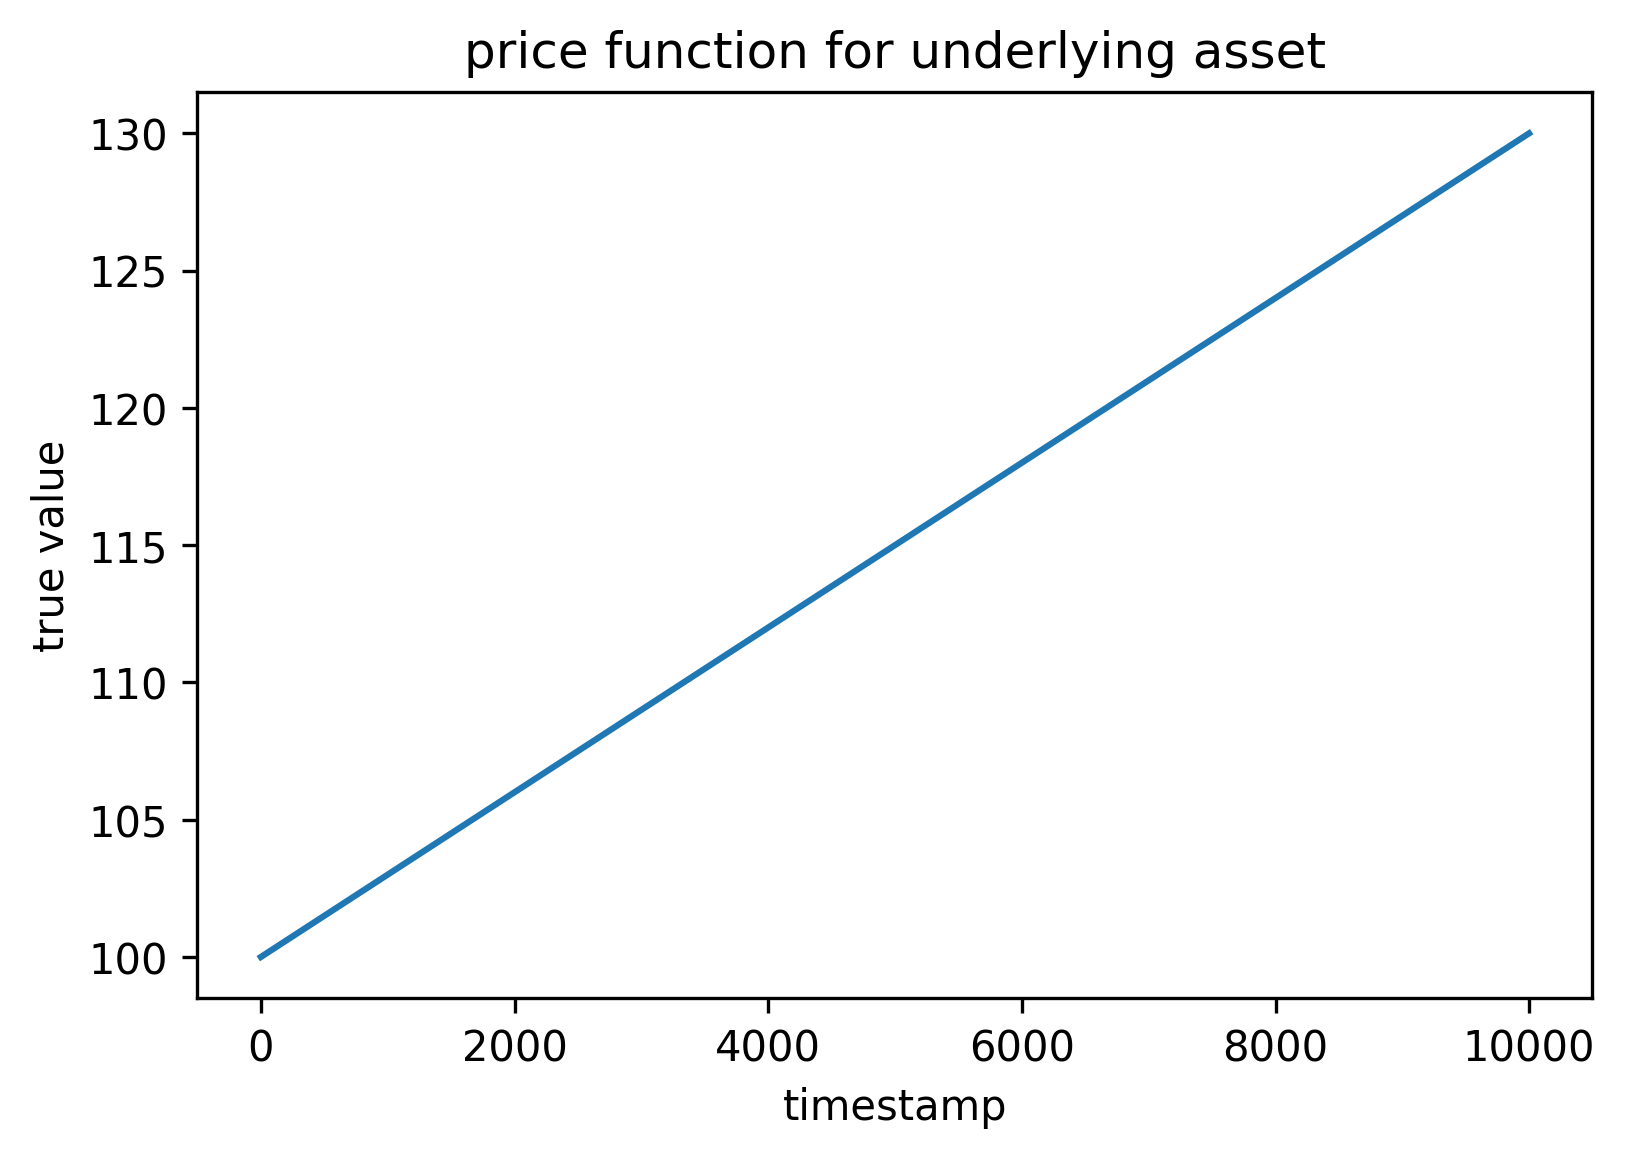

In [9]:
price_function = lambda t: 0.003*t + 100

times = range(10000)
plt.plot([price_function(t) for t in times])
plt.title("price function for underlying asset")
plt.ylabel("true value")
plt.xlabel("timestamp")

In [8]:
import pickle as p
import dill as pickle

In [15]:
# with open("exchange.pickle", "wb") as output_file:
#     pickle.dump(exchanges, output_file)

Text(0.5, 1.0, 'Profit Distribution over 200 simulations')

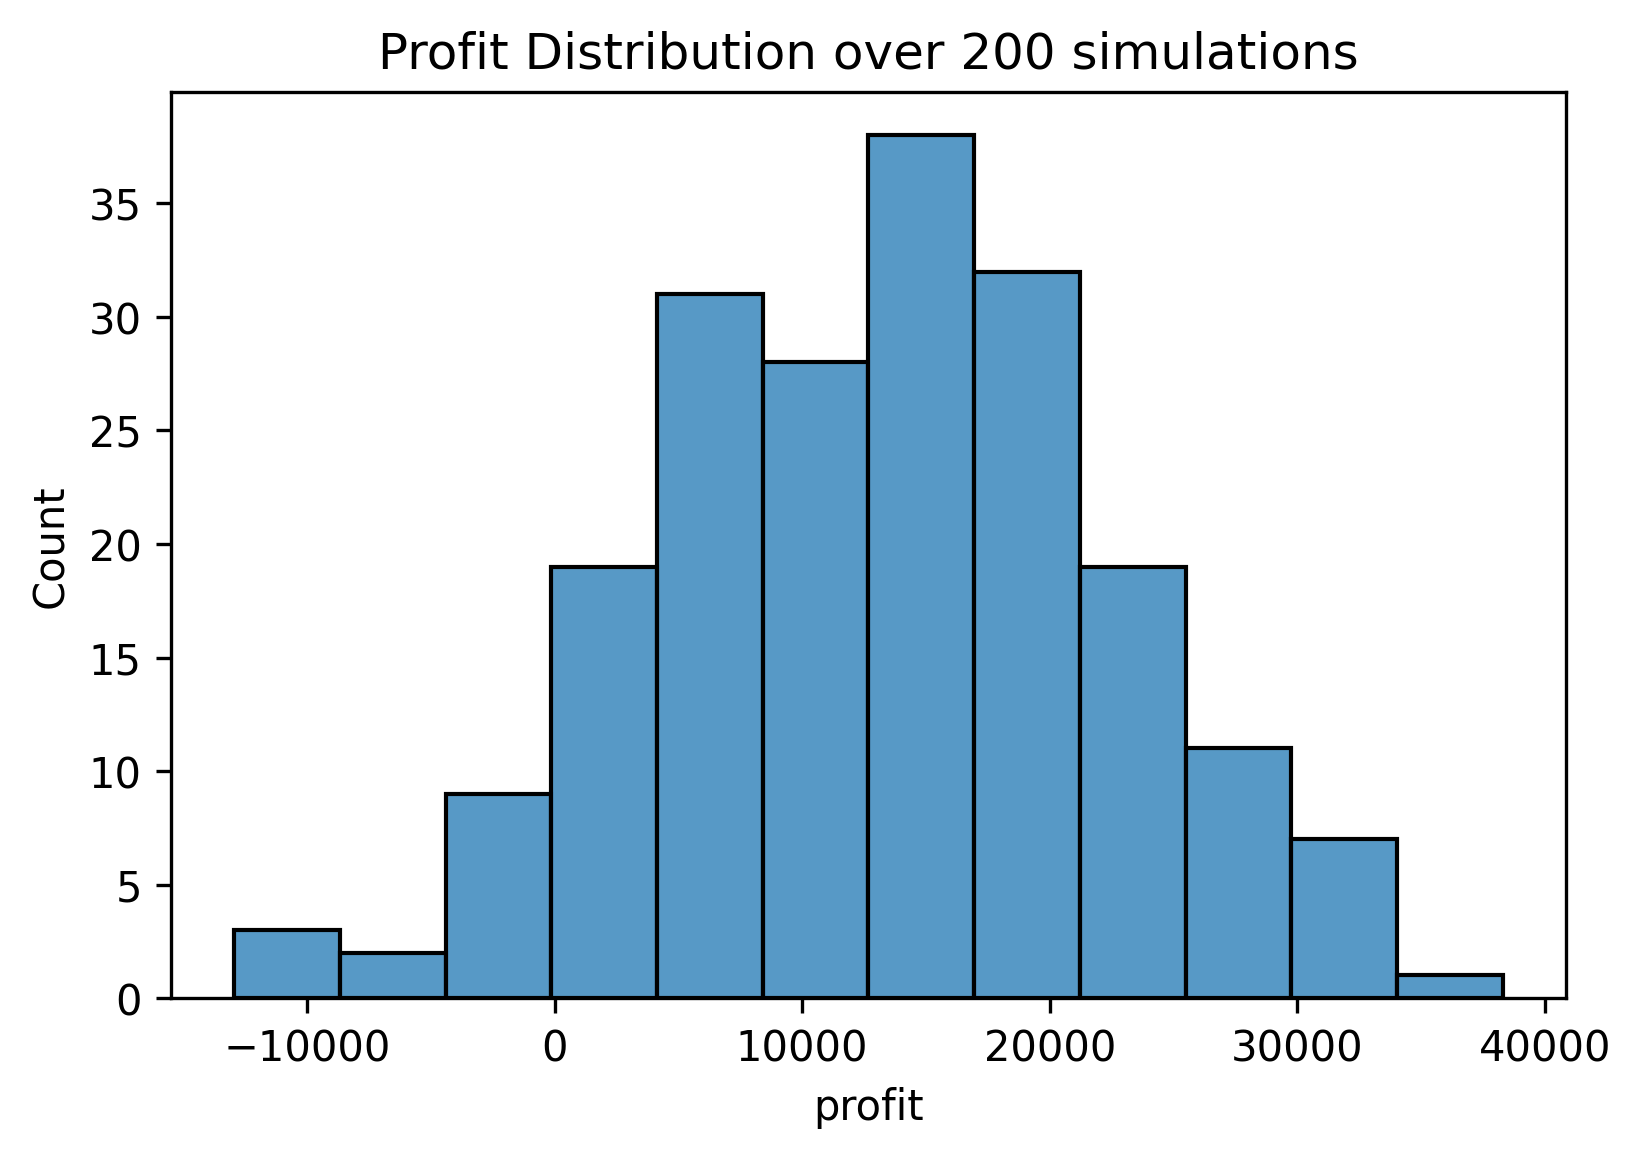

In [10]:
sns.histplot(profits)
plt.xlabel("profit")
plt.title("Profit Distribution over 200 simulations")

In [11]:
# transactions = []
taker_arr = []
maker_arr = []

ask_arr = []
bid_arr = []

for exchange in exchanges:
    takers = 0
    makers = 0
    bids = 0
    asks = 0
    for transaction in exchange.transactions:
        aggressor_id = transaction["aggressor_id"]
        aggressor_order = exchange.orders[aggressor_id]
        if len(aggressor_order) == 2:
            makers += 1
        else: 
            takers += 1
        if transaction["aggressor_side"] == "ask":
            asks += 1
        else: 
            bids += 1
    taker_arr.append(takers)
    maker_arr.append(makers)
    ask_arr.append(asks)
    bid_arr.append(bids)

Text(0, 0.5, 'num makers')

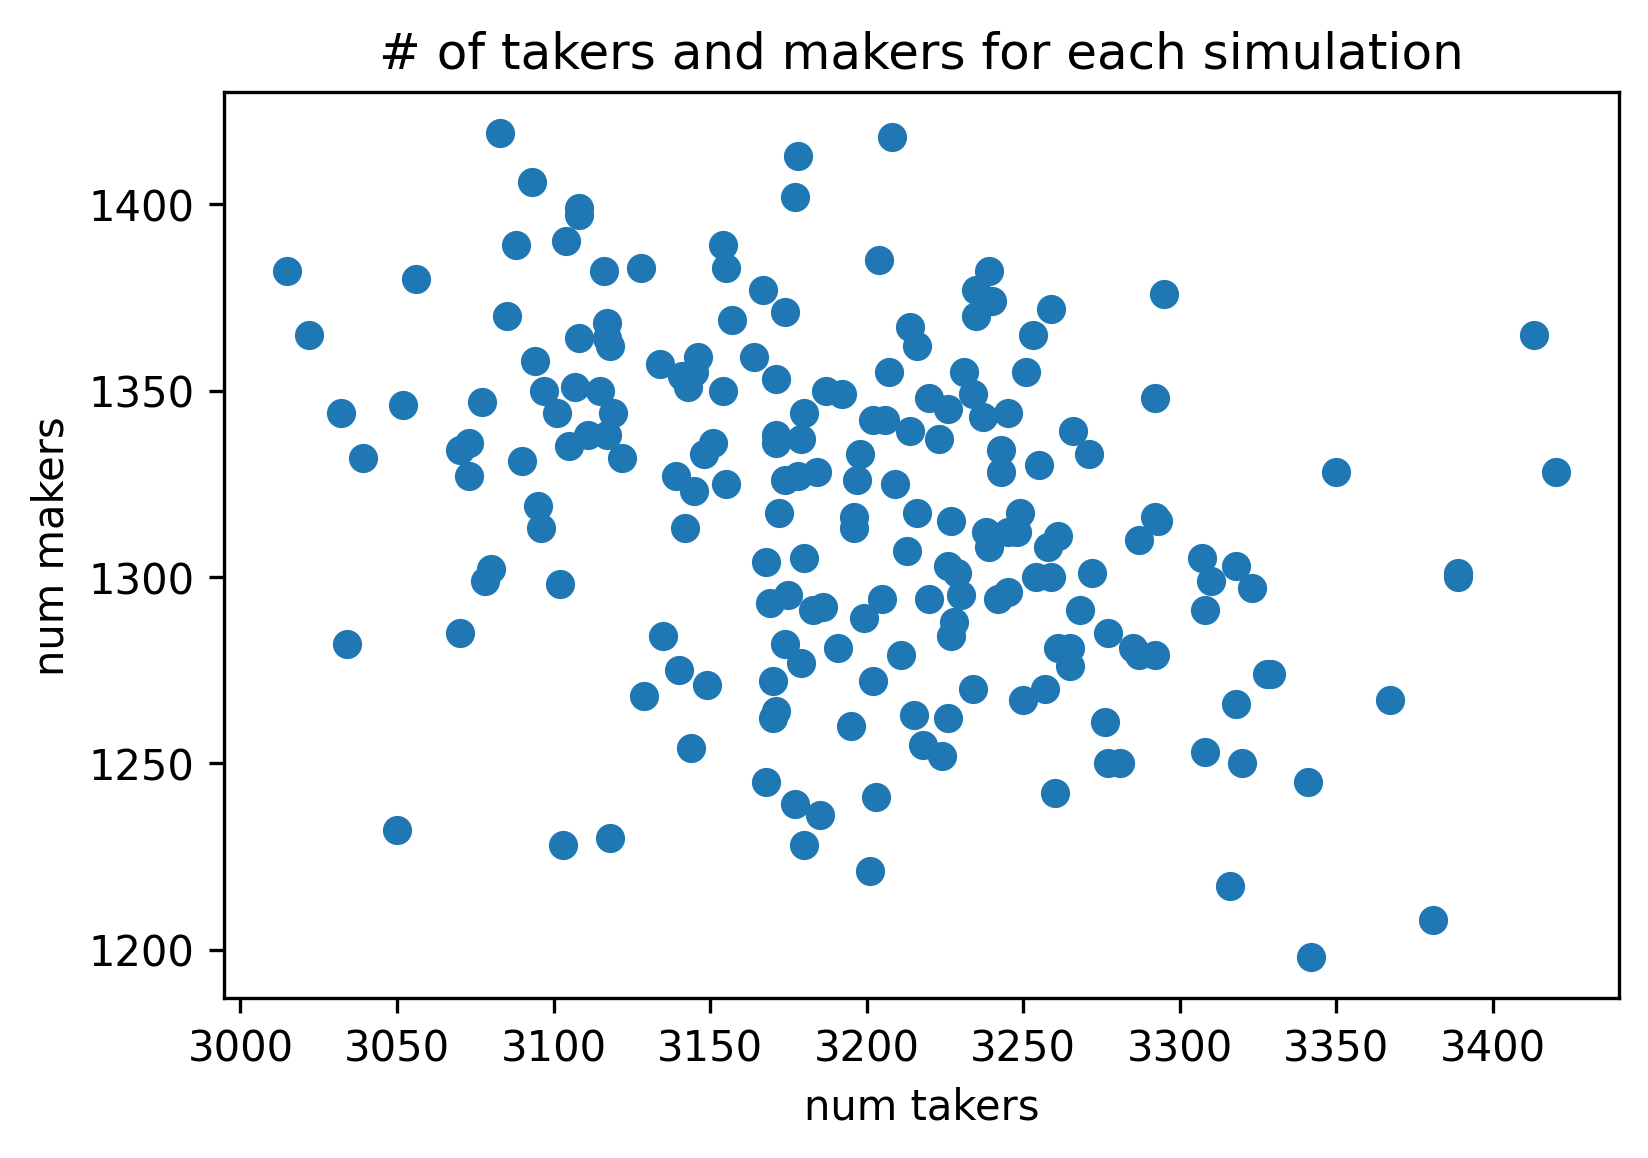

In [20]:
plt.scatter(taker_arr, maker_arr)
plt.title("# of takers and makers for each simulation")
plt.xlabel("num takers")
plt.ylabel("num makers")

Text(0.5, 1.0, 'Distribution of Takers vs Makers on Aggressor-Side of Trades')

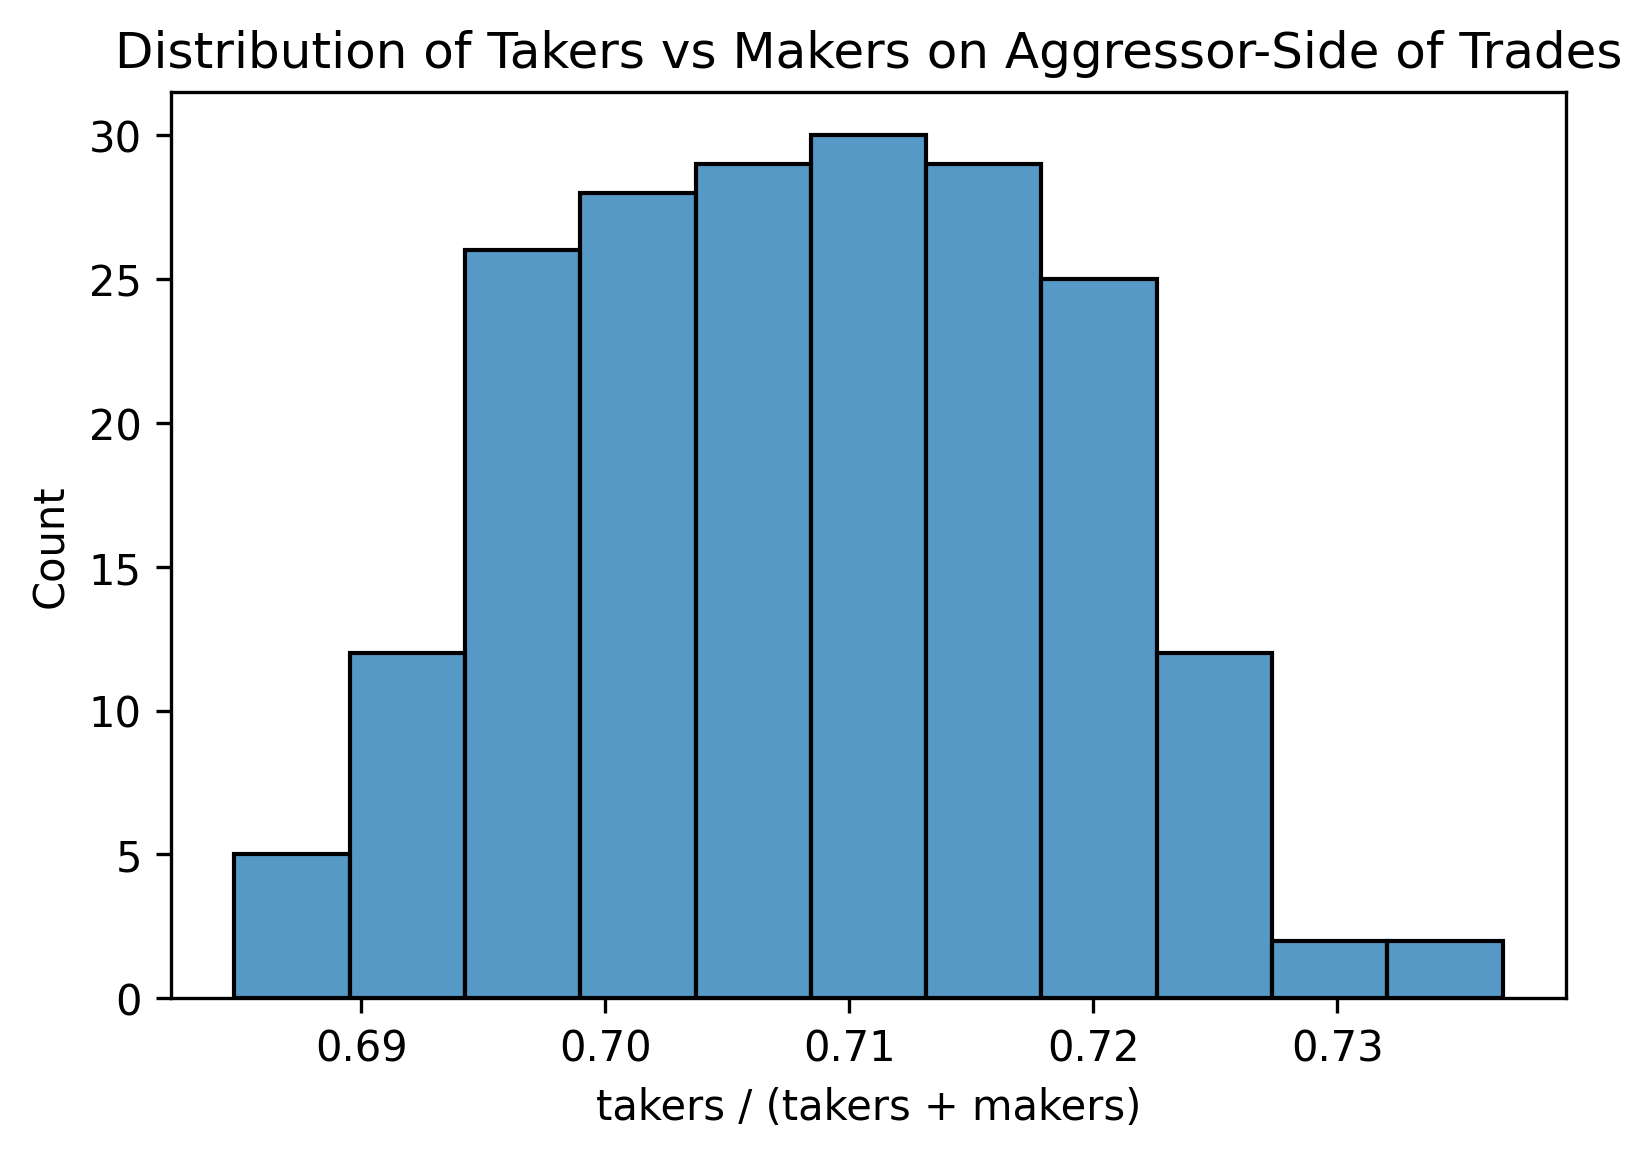

In [13]:
sns.histplot([taker_arr[i] / (taker_arr[i] + maker_arr[i]) for i in range(len(taker_arr))])
plt.xlabel("takers / (takers + makers)")
plt.title("Distribution of Takers vs Makers on Aggressor-Side of Trades")

Text(0.5, 1.0, 'Distribution of Bid vs Ask on Aggressor-Side of Trades')

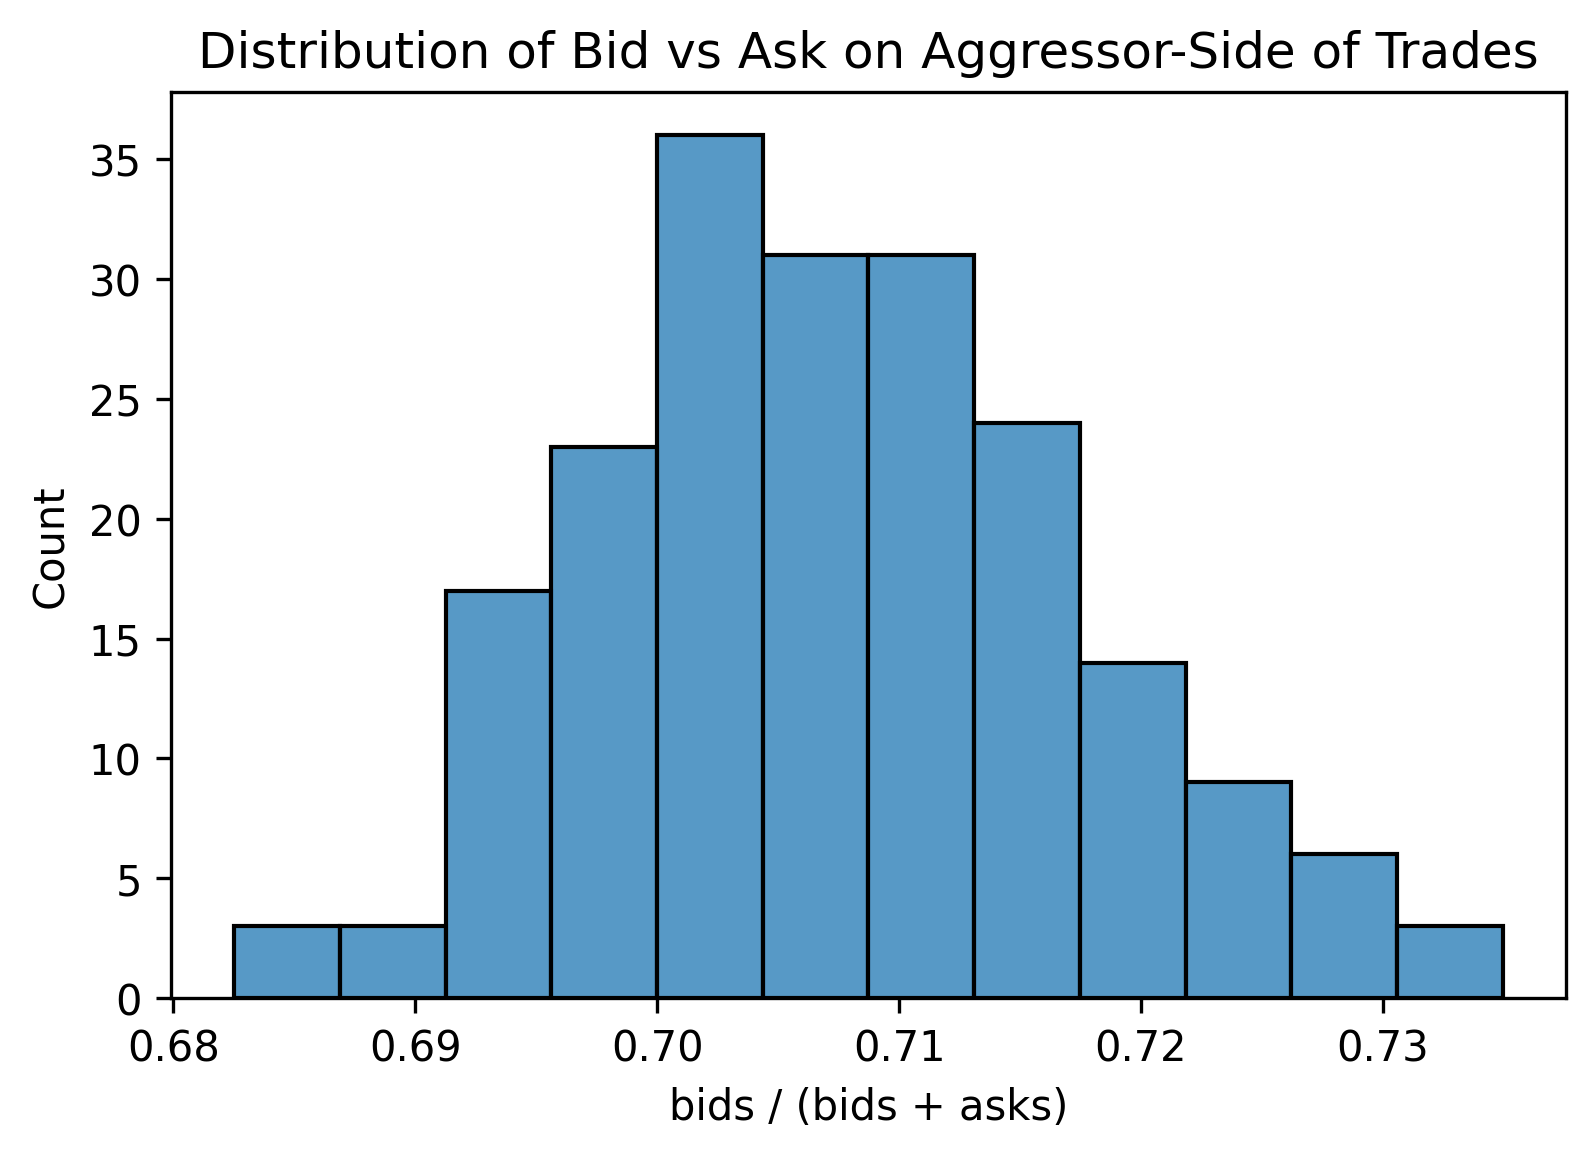

In [14]:
sns.histplot([bid_arr[i] / (bid_arr[i] + ask_arr[i]) for i in range(len(bid_arr))])
plt.xlabel("bids / (bids + asks)")
plt.title("Distribution of Bid vs Ask on Aggressor-Side of Trades")

In [15]:
volumes = []
for summary in summaries:
    summary["trade_volume"] = abs(summary["quantity"])
    volume = summary.groupby("mod_customer_id")["trade_volume"].sum()
    volumes.append(volume)

Text(0.5, 1.0, 'Proportion of Volume Traded from MainCharacter Agent (baseline 0.05)')

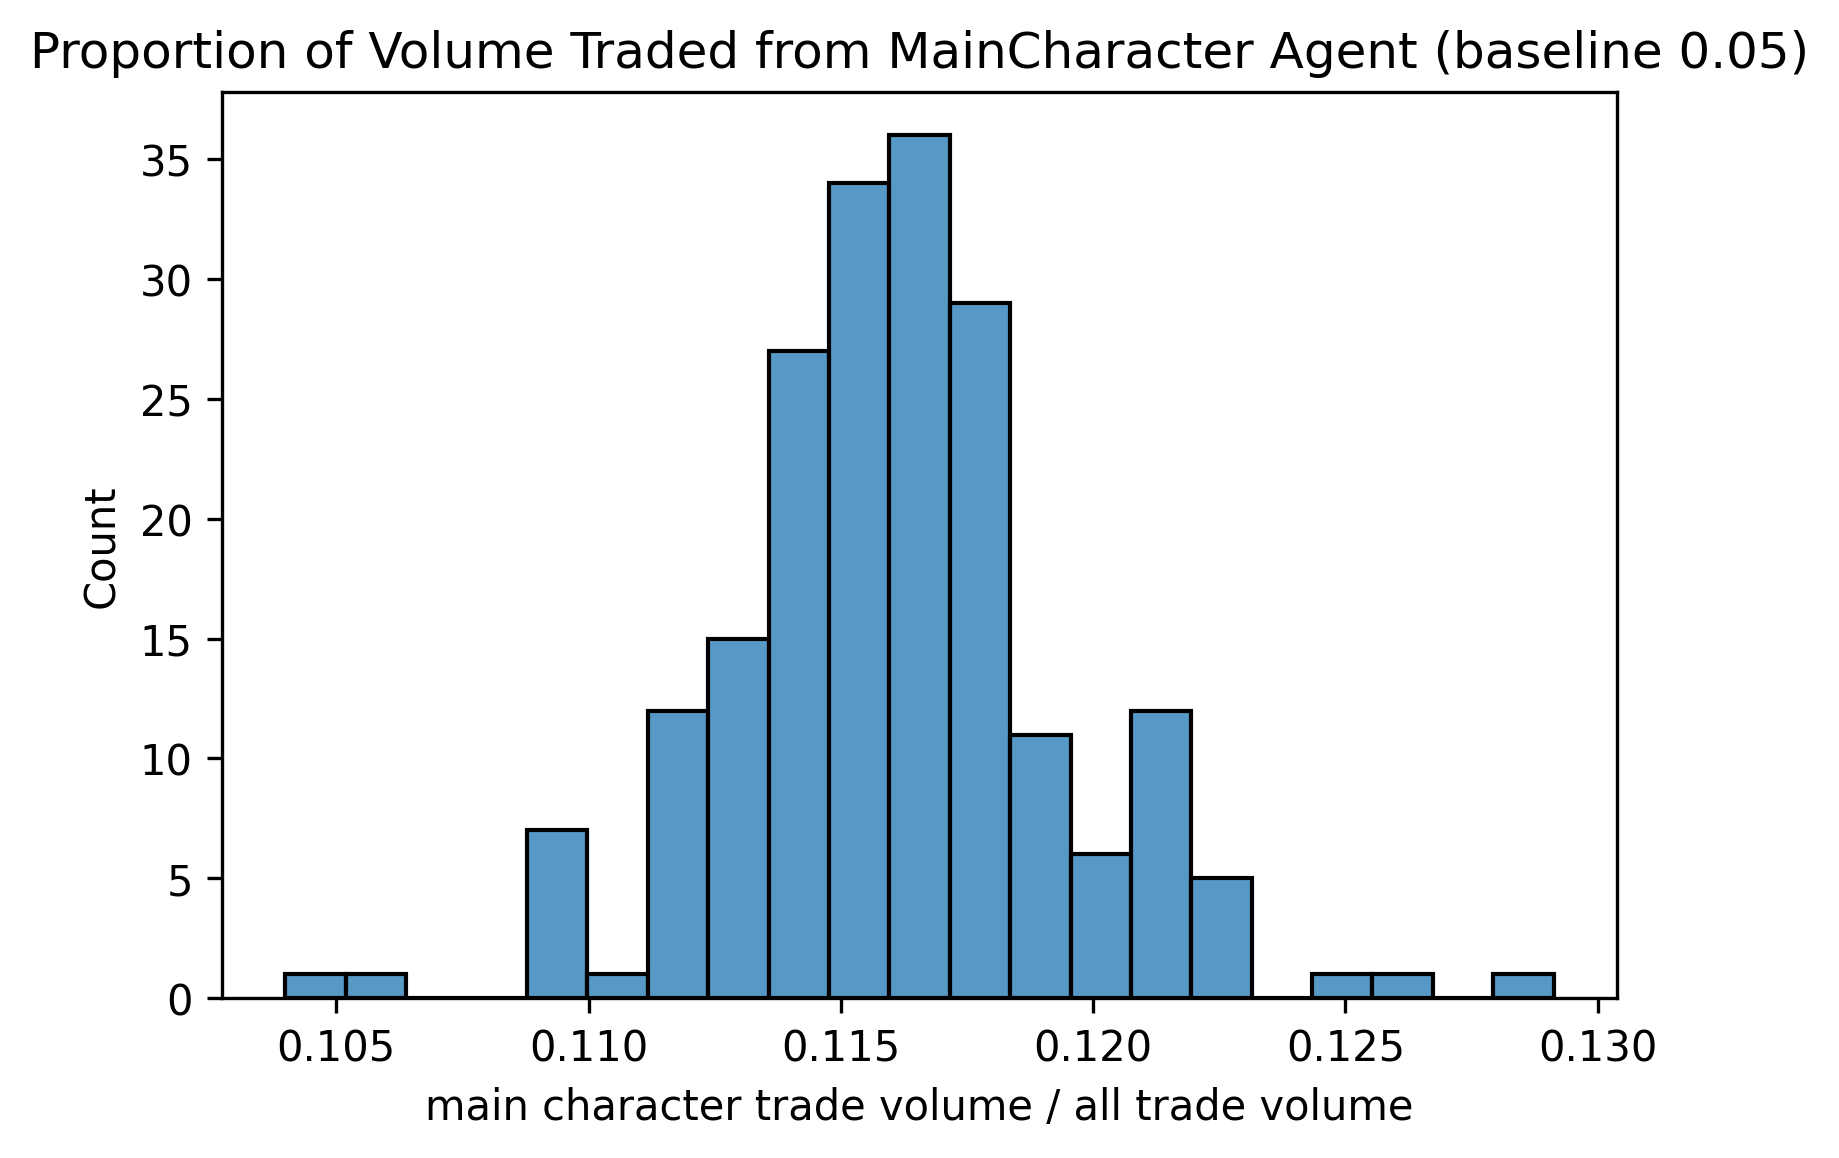

In [16]:
proportions = [v[13.5] / sum(v) for v in volumes]
sns.histplot(proportions)
plt.xlabel("main character trade volume / all trade volume")
plt.title("Proportion of Volume Traded from MainCharacter Agent (baseline 0.05)")

In [17]:
%%capture
profit_proportion = []
for i in range(len(exchanges)):
    exchange = exchanges[i]
    df = summarize_transactions(exchange, price_function, num_agents=20)[1]["profit"]
    profit_proportion.append(df[13.5] / volumes[i][13.5])

Text(0.5, 1.0, 'Relationship between profit per trade and rank')

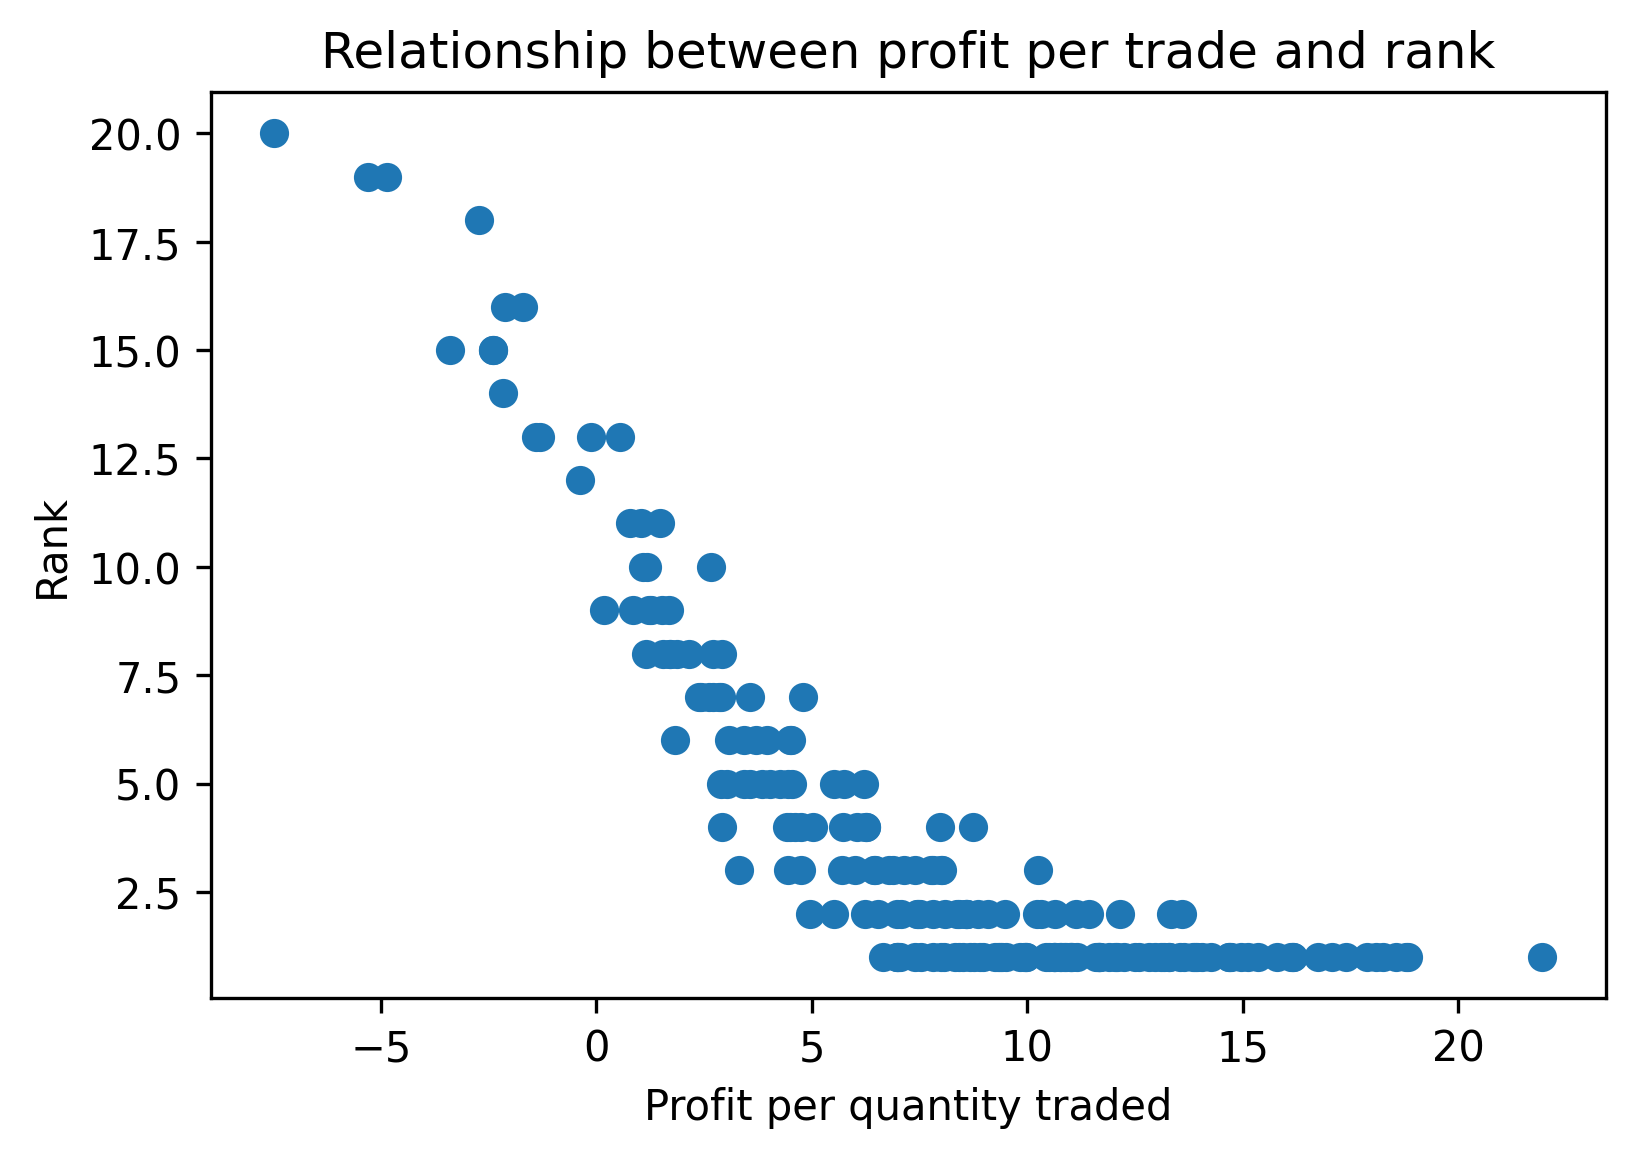

In [18]:
plt.scatter(profit_proportion, ranks)
plt.ylabel("Rank")
plt.xlabel("Profit per quantity traded")
plt.title("Relationship between profit per trade and rank")

Text(0.5, 1.0, 'Distribution of Profit Per Volume Traded')

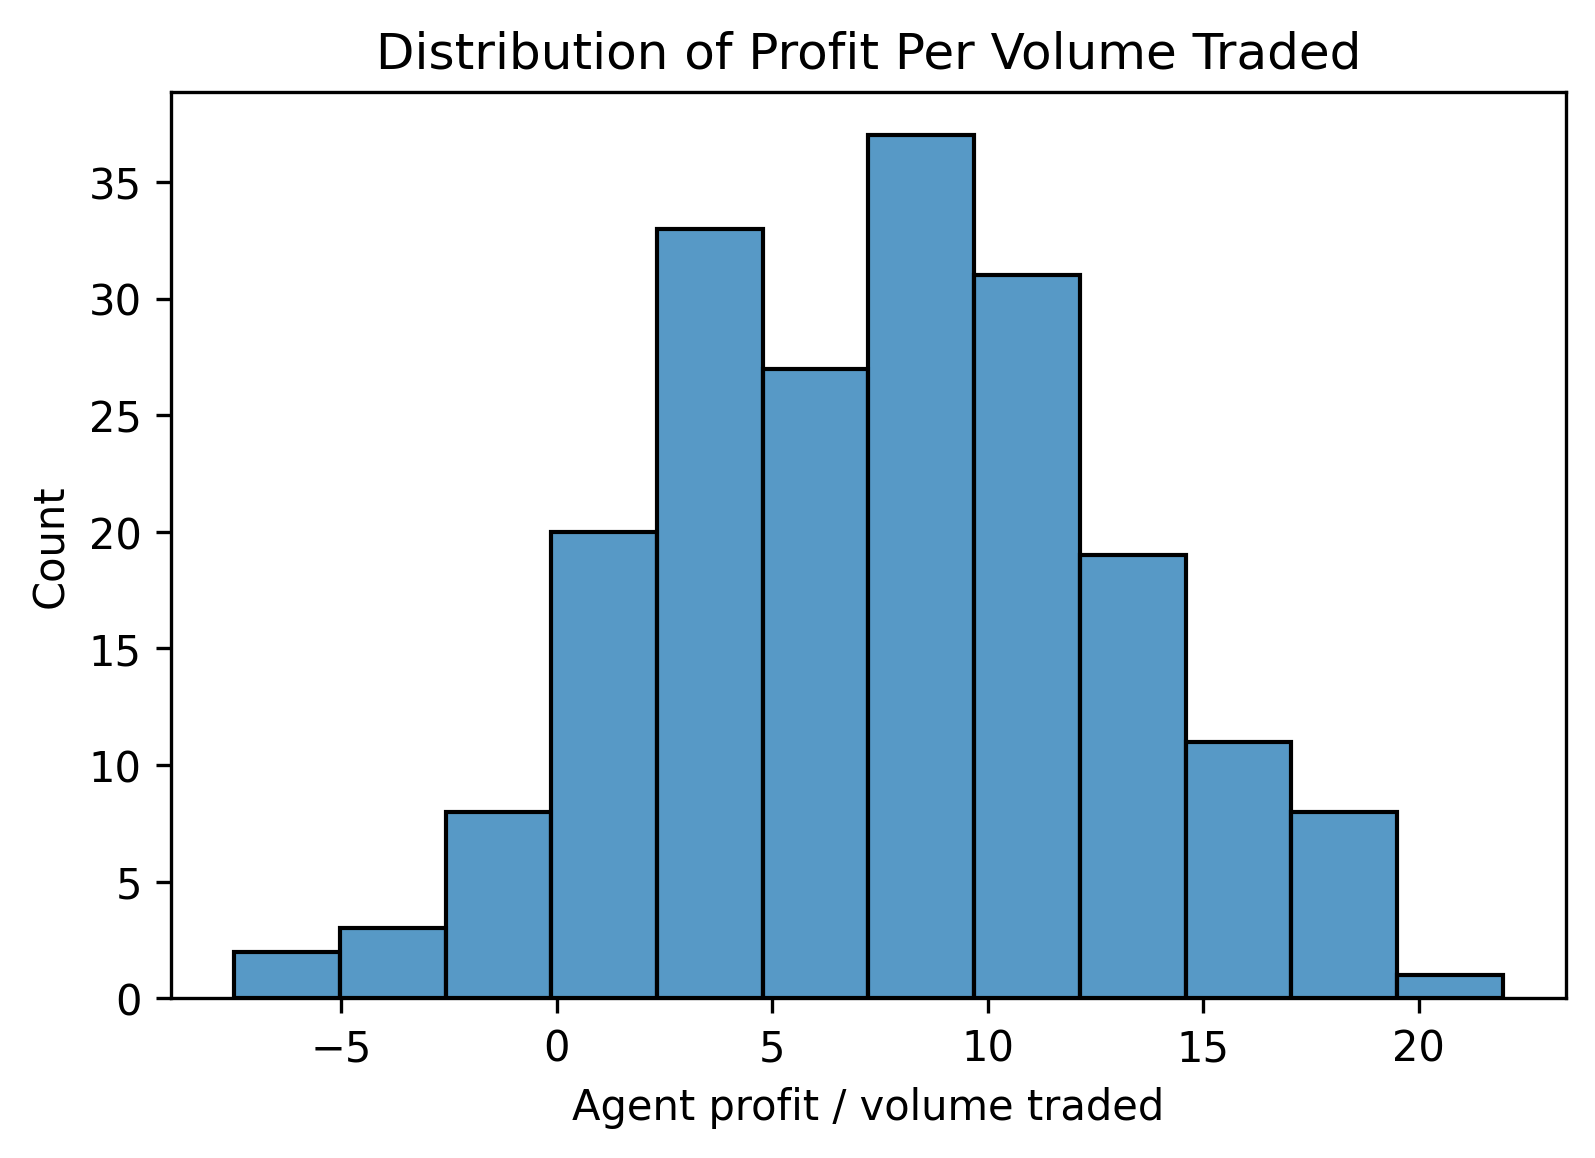

In [19]:
sns.histplot(profit_proportion)
plt.xlabel("Agent profit / volume traded")
plt.title("Distribution of Profit Per Volume Traded")

In [ ]:
''' 
- for each price function, determine best policy
- demonstrate average arrival rate by looking at underlying exchange objects
- track something like average order duration (for orders that get hit)
- track balance between taker ratio and maker ratio for trades that occur (across different price functions)
- determine: under what conditions do trades usually happen?
''' 